# Requesting Argo BGC data from Ifremer erddap, expert mode

Using the expert mode, you can have access to all fields retrieved from the erddap, including all QC variables and without any data mode filtering.

***
Script prepared by [Guillaume Maze](http://github.com/gmaze) (Mar. 2020)

In [1]:
import sys, os
import numpy as np
import xarray as xr

try:
    import argopy
except ModuleNotFoundError:
    !pip install git+http://github.com/euroargodev/argopy.git
    import argopy
print("argopy:", argopy.__version__)
from argopy import DataFetcher as ArgoDataFetcher

#
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import cmocean
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

# Usefull colormaps and colorbar makers:
qcmap = mpl.colors.ListedColormap(['#000000', 
                                   '#31FC03', 
                                   '#ADFC03', 
                                   '#FCBA03', 
                                   '#FC1C03',
                                   '#324CA8', 
                                   '#000000', 
                                   '#000000', 
                                   '#B22CC9', 
                                   '#000000'])
def colorbar_qc(cmap, **kwargs):
    """Adjust colorbar ticks with discrete colors for QC flags"""
    ncolors = 10
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    return colorbar

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(['A','D','R'])

dmode_map = mpl.colors.ListedColormap(['#FCBA03','#31FC03','#FF0000'])
def colorbar_dmode(cmap=dmode_map, **kwargs):
    """Adjust colorbar ticks with discrete colors for DATA MODE"""
    ncolors = 3
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(le.classes_)
    return colorbar

argopy: 0.1


# Create the Argo data loader instance

If we want to retrieve data without post-processing, we need to specify the ``mode`` option to ``expert`` when creating the data loader instance.

In [2]:
argo_loader = ArgoDataFetcher(mode='expert', ds='bgc')
# argo_loader = ArgoDataFetcher(mode='expert', cachedir='tmp')
argo_loader

<datafetcher 'Not initialised'>
Fetchers: 'profile', 'float' or 'region'
User mode: expert

# Example of data fetching for a specific region (Equatorial East-Pacific)

In [3]:
# box = [-120., -85., -10, 10, 0, 1000, '2018-01-01','2018-12-31']
box = [-120., -85., -10, 10, 0, 1000, '2019-01-01','2019-12-31']
ds = argo_loader.region(box).to_xarray()
ds

<xarray.Dataset>
Dimensions:              (index: 17019)
Coordinates:
    latitude             (index) float64 9.865 9.865 9.865 ... 9.991 9.991 9.991
  * index                (index) int64 0 1 2 3 4 ... 17015 17016 17017 17018
    time                 (index) datetime64[ns] 2019-04-10T18:47:00 ... 2019-08-08T18:42:00
    longitude            (index) float64 -106.4 -106.4 -106.4 ... -105.0 -105.0
Data variables:
    CYCLE_NUMBER         (index) int64 179 179 179 179 179 ... 203 203 203 203
    DATA_MODE            (index) <U1 'R' 'R' 'R' 'R' 'R' ... 'R' 'A' 'A' 'R' 'A'
    DIRECTION            (index) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
    DOXY                 (index) float64 nan 178.1 177.9 nan ... nan 25.08 nan
    DOXY_ADJUSTED        (index) float64 nan nan nan nan nan ... nan nan nan nan
    DOXY_ADJUSTED_ERROR  (index) float64 nan nan nan nan nan ... nan nan nan nan
    DOXY_ADJUSTED_QC     (index) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    DOXY_QC              (index) int64 0 1 1 0 0 1 0 0 1 1 ... 1 0 1 0 1 0 0 1 0
    PLATFORM_NUMBER      (index) int64 3901530 3901530 ... 3901530 3901530
    POSITION_QC          (index) int64 1 1 1 1 1 1 1 1 1 1 ... 8 8 8 8 8 8 8 8 8
    PRES                 (index) float64 0.5 0.5 1.4 1.5 ... 985.0 987.3 993.1
    PRES_ADJUSTED        (index) float64 nan nan nan nan ... 985.0 nan 993.1
    PRES_ADJUSTED_ERROR  (index) float64 nan nan nan nan nan ... nan nan nan nan
    PRES_ADJUSTED_QC     (index) int64 0 0 0 0 0 0 0 0 0 0 ... 0 1 0 1 0 1 1 0 1
    PRES_QC              (index) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    PSAL                 (index) float64 33.02 nan nan 33.05 ... 34.58 nan 34.58
    PSAL_ADJUSTED        (index) float64 nan nan nan nan ... 34.58 nan 34.58
    PSAL_ADJUSTED_ERROR  (index) float64 nan nan nan nan nan ... nan nan nan nan
    PSAL_ADJUSTED_QC     (index) int64 0 0 0 0 0 0 0 0 0 0 ... 0 1 0 1 0 1 1 0 1
    PSAL_QC              (index) int64 3 0 0 3 3 0 1 1 0 0 ... 0 1 0 1 0 1 1 0 1
    TEMP                 (index) float64 29.38 nan nan 29.34 ... 4.448 nan 4.412
    TEMP_ADJUSTED        (index) float64 nan nan nan nan ... 4.448 nan 4.412
    TEMP_ADJUSTED_ERROR  (index) float64 nan nan nan nan nan ... nan nan nan nan
    TEMP_ADJUSTED_QC     (index) int64 0 0 0 0 0 0 0 0 0 0 ... 0 1 0 1 0 1 1 0 1
    TEMP_QC              (index) int64 3 0 0 1 1 0 1 1 0 0 ... 0 1 0 1 0 1 1 0 1
    TIME_QC              (index) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:               ARGO-BGC
    DOI:                   http://doi.org/10.17882/42182
    Downloaded_from:       http://www.ifremer.fr/erddap
    Downloaded_by:         gmaze
    Download_date:         2020/03/17
    Download_url:          http://www.ifremer.fr/erddap/tabledap/ArgoFloats-b...
    Download_constraints:  bgc_[x=-120.00/-85.00; y=-10.00/10.00; z=0.0/1000....

## QC figure with unfiltered data

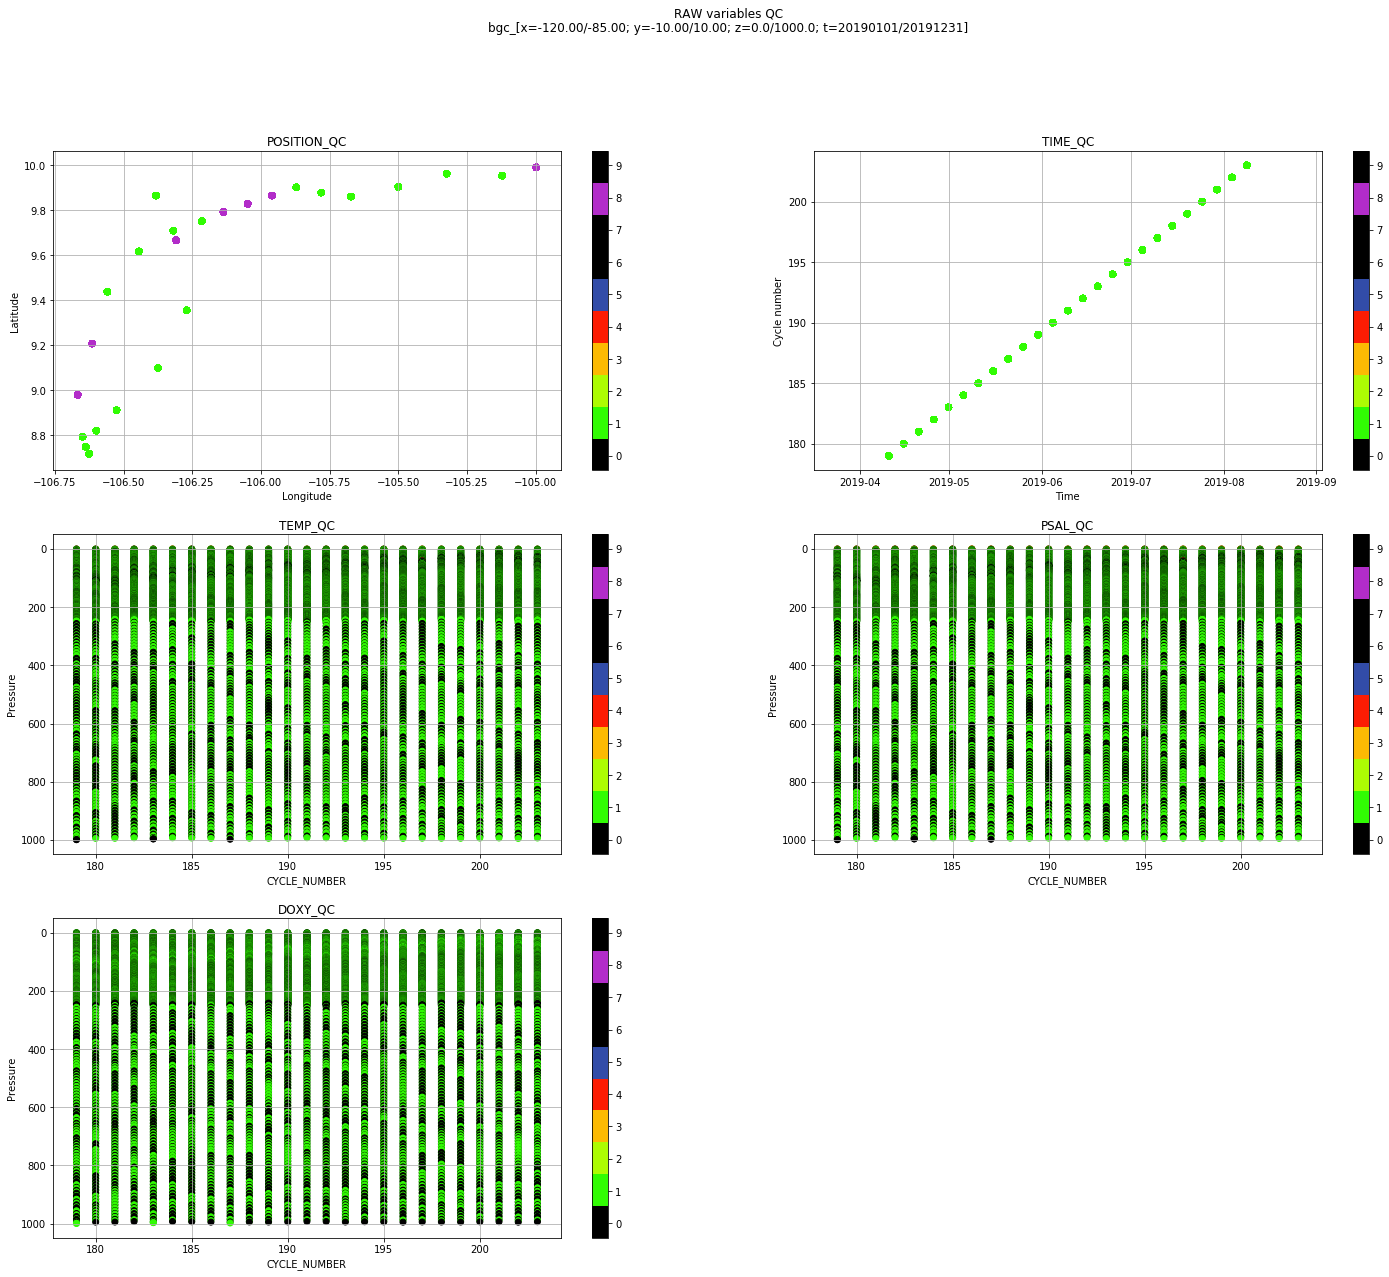

In [4]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(25,20))
ax = np.array(ax).flatten()
fig.delaxes(ax[-1])

ix = 0
sc = ax[ix].scatter(ds['longitude'], ds['latitude'], c=ds['POSITION_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].set_xlabel('Longitude')
ax[ix].set_ylabel('Latitude')
ax[ix].set_title('POSITION_QC')

ix += 1
sc = ax[ix].scatter(ds['time'].values, ds['CYCLE_NUMBER'], c=ds['TIME_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].set_xlabel('Time')
ax[ix].set_ylabel('Cycle number')
ax[ix].set_title('TIME_QC')

ix += 1
sc = ax[ix].scatter(ds['CYCLE_NUMBER'], ds['PRES'], c=ds['TEMP_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel('CYCLE_NUMBER')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('TEMP_QC')

ix += 1
sc = ax[ix].scatter(ds['CYCLE_NUMBER'], ds['PRES'], c=ds['PSAL_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel('CYCLE_NUMBER')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('PSAL_QC')

ix += 1
sc = ax[ix].scatter(ds['CYCLE_NUMBER'], ds['PRES'], c=ds['DOXY_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel('CYCLE_NUMBER')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('DOXY_QC')

fig.suptitle("RAW variables QC\n%s" % ds.attrs['Download_constraints']);

# Filter data according to data mode

But this is (nearly) the raw output of the request. It could be useful to simply select the most appropriate variables according to the data mode (Real time, adjusted and delayed mode). 

Note that this is done automatically in ``mode='standard'``.

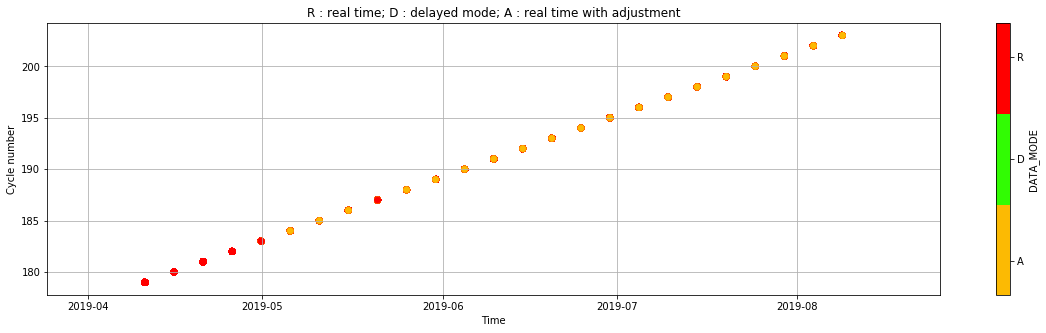

In [5]:
# Inspect data mode
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
ax = np.array(ax).flatten()
sc = ax[0].scatter(ds['time'].values, ds['CYCLE_NUMBER'], c=le.transform(ds['DATA_MODE']), 
            vmin=0, vmax=2, cmap=dmode_map)
colorbar_dmode(label='DATA_MODE', ax=ax[0])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Cycle number')
ax[0].grid()
ax[0].set_title(ds['DATA_MODE'].attrs['convention']);

## Filter data according to data mode

In [6]:
ds_filtered = argo_loader.region(box).fetcher.filter_data_mode(ds)

## QC figure with appropriate variables

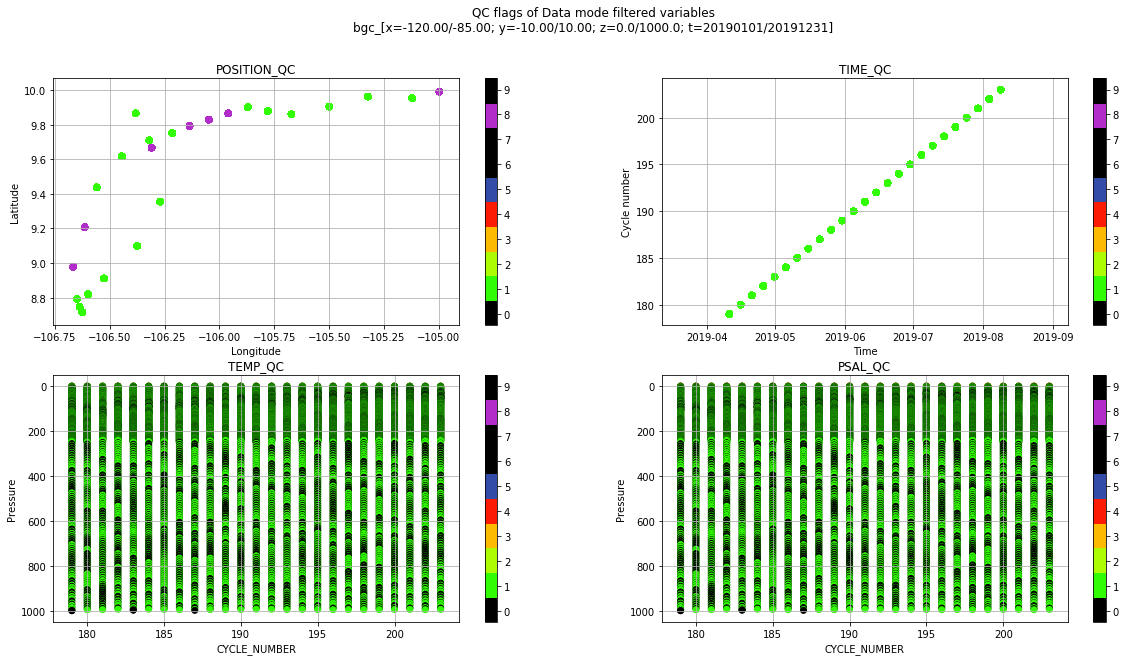

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(ds_filtered['longitude'], ds_filtered['latitude'], c=ds_filtered['POSITION_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].set_xlabel('Longitude')
ax[ix].set_ylabel('Latitude')
ax[ix].set_title('POSITION_QC')

ix += 1
sc = ax[ix].scatter(ds_filtered['time'].values, ds_filtered['CYCLE_NUMBER'], c=ds_filtered['TIME_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].set_xlabel('Time')
ax[ix].set_ylabel('Cycle number')
ax[ix].set_title('TIME_QC')

ix += 1
sc = ax[ix].scatter(ds_filtered['CYCLE_NUMBER'], ds_filtered['PRES'], c=ds_filtered['TEMP_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel('CYCLE_NUMBER')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('TEMP_QC')

ix += 1
sc = ax[ix].scatter(ds_filtered['CYCLE_NUMBER'], ds_filtered['PRES'], c=ds_filtered['PSAL_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel('CYCLE_NUMBER')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('PSAL_QC')

fig.suptitle("QC flags of Data mode filtered variables\n%s" % ds.attrs['Download_constraints']);

# Example of data fetching for a specific float

In [9]:
float_fetcher = argo_loader.float(3901530)
# float_fetcher = argo_loader.float(6902746)
# float_fetcher = argo_loader.region([-180,180,0,90,0,1000])
# float_fetcher = argo_loader.float(2903005) # Float with a RBRargo sensor
float_fetcher

<datafetcher 'Ifremer erddap Argo data fetcher'>
Domain: bgc_WMO3901530
User mode: expert

In [10]:
ds_unfiltered = float_fetcher.to_xarray()
ds = float_fetcher.fetcher.filter_data_mode(ds_unfiltered)
ds

<xarray.Dataset>
Dimensions:          (index: 234964)
Coordinates:
    latitude         (index) float64 15.0 15.0 15.0 15.0 ... 10.19 10.19 10.19
  * index            (index) int64 0 1 2 3 4 ... 234960 234961 234962 234963
    time             (index) datetime64[ns] 2016-11-28T21:00:00 ... 2019-09-17T19:04:00
    longitude        (index) float64 -110.0 -110.0 -110.0 ... -105.3 -105.3
Data variables:
    CYCLE_NUMBER     (index) int64 1 1 1 1 1 1 1 ... 211 211 211 211 211 211 211
    DATA_MODE        (index) <U1 'A' 'R' 'R' 'R' 'R' 'R' ... 'A' 'R' 'A' 'A' 'R'
    DIRECTION        (index) <U1 'D' 'D' 'D' 'D' 'D' 'D' ... 'A' 'A' 'A' 'A' 'A'
    DOXY             (index) float64 nan nan 187.8 nan ... 21.33 nan nan 23.09
    DOXY_ERROR       (index) float64 nan nan nan nan nan ... nan nan nan nan nan
    DOXY_QC          (index) int64 0 0 1 0 0 0 0 1 0 0 0 ... 1 0 1 0 1 0 1 0 0 1
    PLATFORM_NUMBER  (index) int64 3901530 3901530 3901530 ... 3901530 3901530
    POSITION_QC      (index) int64 8 8 8 8 8 8 8 8 8 8 8 ... 8 8 8 8 8 8 8 8 8 8
    PRES             (index) float64 nan 18.6 18.6 ... 993.0 1.009e+03 1.014e+03
    PRES_ERROR       (index) float64 nan nan nan nan nan ... nan nan nan nan nan
    PRES_QC          (index) int64 0 1 1 1 1 1 0 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    PSAL             (index) float64 nan 33.73 nan nan ... nan 34.58 34.58 nan
    PSAL_ERROR       (index) float64 nan nan nan nan nan ... nan nan nan nan nan
    PSAL_QC          (index) int64 0 1 0 0 1 0 0 0 1 1 0 ... 0 1 0 1 0 1 0 1 1 0
    TEMP             (index) float64 nan 29.4 nan nan ... nan 4.536 4.461 nan
    TEMP_ERROR       (index) float64 nan nan nan nan nan ... nan nan nan nan nan
    TEMP_QC          (index) int64 0 1 0 0 1 0 0 0 1 1 0 ... 0 1 0 1 0 1 0 1 1 0
    TIME_QC          (index) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:               ARGO-BGC
    DOI:                   http://doi.org/10.17882/42182
    Downloaded_from:       http://www.ifremer.fr/erddap
    Downloaded_by:         gmaze
    Download_date:         2020/03/17
    Download_url:          http://www.ifremer.fr/erddap/tabledap/ArgoFloats-b...
    Download_constraints:  bgc_WMO3901530
    history:               Variables selected according to DATA_MODE

In [11]:
# Get basic information about the float:
print('This float has performed: %i profiles' % len(np.unique(ds['CYCLE_NUMBER'])))
print('This float operated between %s and %s' % (ds['time'].min().values, ds['time'].max().values))
print('This float profiles range from %0.1fdb to %0.1fdb' % (ds['PRES'].min(), ds['PRES'].max() ))

This float has performed: 210 profiles
This float operated between 2016-11-28T21:00:00.000000000 and 2019-09-17T19:04:00.000000000
This float profiles range from 0.0db to 1049.1db


## Plot trajectory

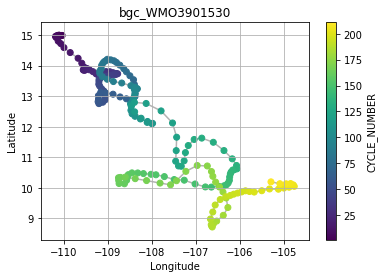

In [12]:
this = ds.reset_coords().groupby('CYCLE_NUMBER').min()
plt.plot(this['longitude'], this['latitude'], '-', color=[0.7]*3, zorder=0)
plt.scatter(this['longitude'], this['latitude'], c=this['CYCLE_NUMBER'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.gca().grid()
plt.colorbar(label='CYCLE_NUMBER')
plt.title(ds.attrs['Download_constraints'])
plt.show()

## QC flags for appropriate variables

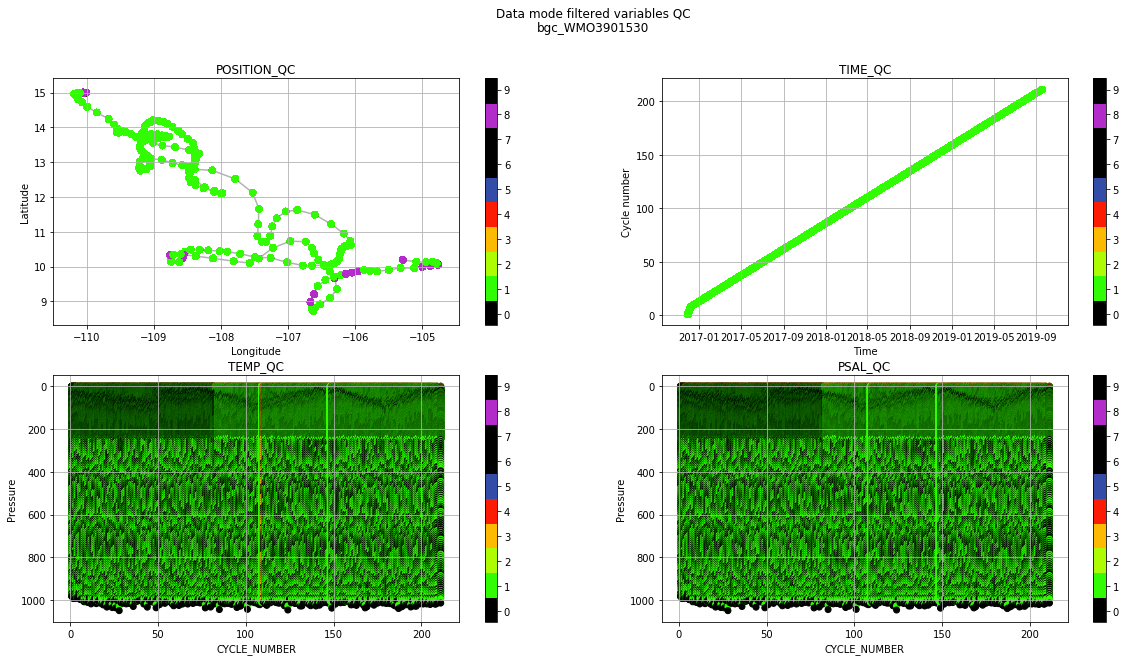

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = np.array(ax).flatten()

ix = 0
ax[ix].plot(ds['longitude'], ds['latitude'], '-', color=[0.7]*3, zorder=0)
sc = ax[ix].scatter(ds['longitude'], ds['latitude'], c=ds['POSITION_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].set_xlabel('Longitude')
ax[ix].set_ylabel('Latitude')
ax[ix].set_title('POSITION_QC')

ix += 1
sc = ax[ix].scatter(ds['time'].values, ds['CYCLE_NUMBER'], c=ds['TIME_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].set_xlabel('Time')
ax[ix].set_ylabel('Cycle number')
ax[ix].set_title('TIME_QC')

ix += 1
sc = ax[ix].scatter(ds['CYCLE_NUMBER'], ds['PRES'], c=ds['TEMP_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel('CYCLE_NUMBER')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('TEMP_QC')

ix += 1
sc = ax[ix].scatter(ds['CYCLE_NUMBER'], ds['PRES'], c=ds['PSAL_QC'], vmin=0, vmax=9, cmap=qcmap)
colorbar_qc(qcmap, ax=ax[ix])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel('CYCLE_NUMBER')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('PSAL_QC')

fig.suptitle("Data mode filtered variables QC\n%s" % ds.attrs['Download_constraints']);

## DATA MODE

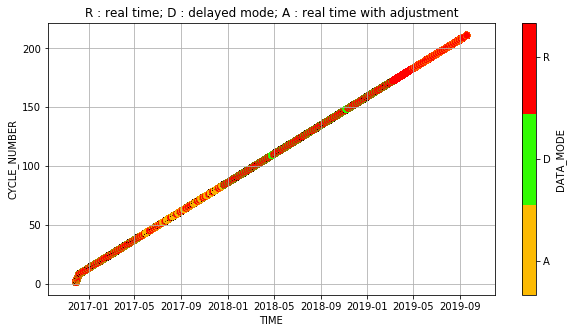

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax = np.array(ax).flatten()
sc = ax[0].scatter(ds['time'].values, ds['CYCLE_NUMBER'], c=le.transform(ds['DATA_MODE']), 
            vmin=0, vmax=2, cmap=dmode_map)
colorbar_dmode(label='DATA_MODE', ax=ax[0])
ax[0].set_ylabel('CYCLE_NUMBER')
ax[0].set_xlabel('TIME')
ax[0].grid()
ax[0].set_title(ds['DATA_MODE'].attrs['convention']);

## Hovmoller

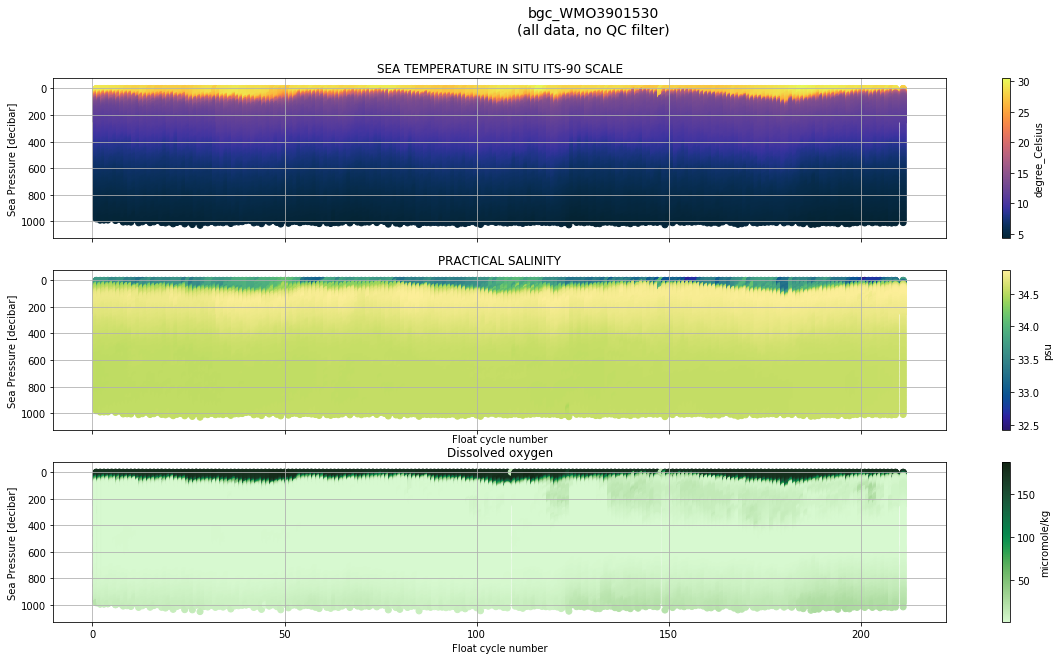

In [26]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,10), sharex=True, sharey=True)
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(ds['CYCLE_NUMBER'], ds['PRES'], c=ds['TEMP'], cmap=cmocean.cm.thermal)
plt.colorbar(sc, ax=ax[ix], label=ds['TEMP'].attrs['units'])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_ylabel("%s [%s]" % (ds['PRES'].attrs['long_name'], ds['PRES'].attrs['units']))
ax[ix].set_title(ds['TEMP'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(ds['CYCLE_NUMBER'], ds['PRES'], c=ds['PSAL'], cmap=cmocean.cm.haline)
plt.colorbar(sc, ax=ax[ix], label=ds['PSAL'].attrs['units'])
ax[ix].grid()
ax[ix].set_xlabel(ds['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].set_ylabel("%s [%s]" % (ds['PRES'].attrs['long_name'], ds['PRES'].attrs['units']))
ax[ix].set_title(ds['PSAL'].attrs['long_name']);

ix += 1
sc = ax[ix].scatter(ds['CYCLE_NUMBER'], ds['PRES'], c=ds['DOXY'], cmap=cmocean.cm.algae)
plt.colorbar(sc, ax=ax[ix], label=ds['DOXY'].attrs['units'])
ax[ix].grid()
ax[ix].set_xlabel(ds['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].set_ylabel("%s [%s]" % (ds['PRES'].attrs['long_name'], ds['PRES'].attrs['units']))
ax[ix].set_title(ds['DOXY'].attrs['long_name']);

fig.suptitle("%s\n(all data, no QC filter)" % ds.attrs['Download_constraints'], fontsize=14);

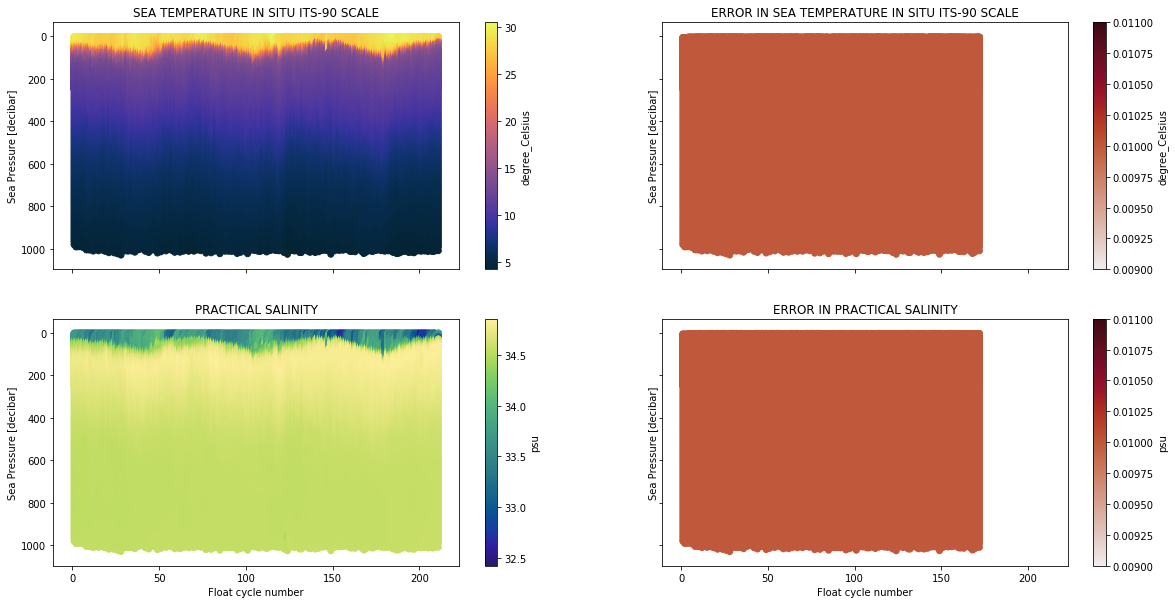

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10), sharex=True, sharey=True)
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(ds['CYCLE_NUMBER'], ds['PRES'], c=ds['TEMP'], cmap=cmocean.cm.thermal)
plt.colorbar(sc, ax=ax[ix], label=ds['TEMP'].attrs['units'])
ax[ix].invert_yaxis()
ax[ix].set_ylabel("%s [%s]" % (ds['PRES'].attrs['long_name'], ds['PRES'].attrs['units']))
ax[ix].set_title(ds['TEMP'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(ds['CYCLE_NUMBER'], ds['PRES'], c=ds['TEMP_ERROR'], cmap=cmocean.cm.amp)
plt.colorbar(sc, ax=ax[ix], label=ds['TEMP_ERROR'].attrs['units'])
ax[ix].set_ylabel("%s [%s]" % (ds['PRES'].attrs['long_name'], ds['PRES'].attrs['units']))
ax[ix].set_title(ds['TEMP_ERROR'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(ds['CYCLE_NUMBER'], ds['PRES'], c=ds['PSAL'], cmap=cmocean.cm.haline)
plt.colorbar(sc, ax=ax[ix], label=ds['PSAL'].attrs['units'])
ax[ix].set_xlabel(ds['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].set_ylabel("%s [%s]" % (ds['PRES'].attrs['long_name'], ds['PRES'].attrs['units']))
ax[ix].set_title(ds['PSAL'].attrs['long_name']);

ix += 1
sc = ax[ix].scatter(ds['CYCLE_NUMBER'], ds['PRES'], c=ds['PSAL_ERROR'], cmap=cmocean.cm.amp)
plt.colorbar(sc, ax=ax[ix], label=ds['PSAL_ERROR'].attrs['units'])
ax[ix].set_xlabel(ds['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].set_ylabel("%s [%s]" % (ds['PRES'].attrs['long_name'], ds['PRES'].attrs['units']))
ax[ix].set_title(ds['PSAL_ERROR'].attrs['long_name']);

## Super-imposed profiles

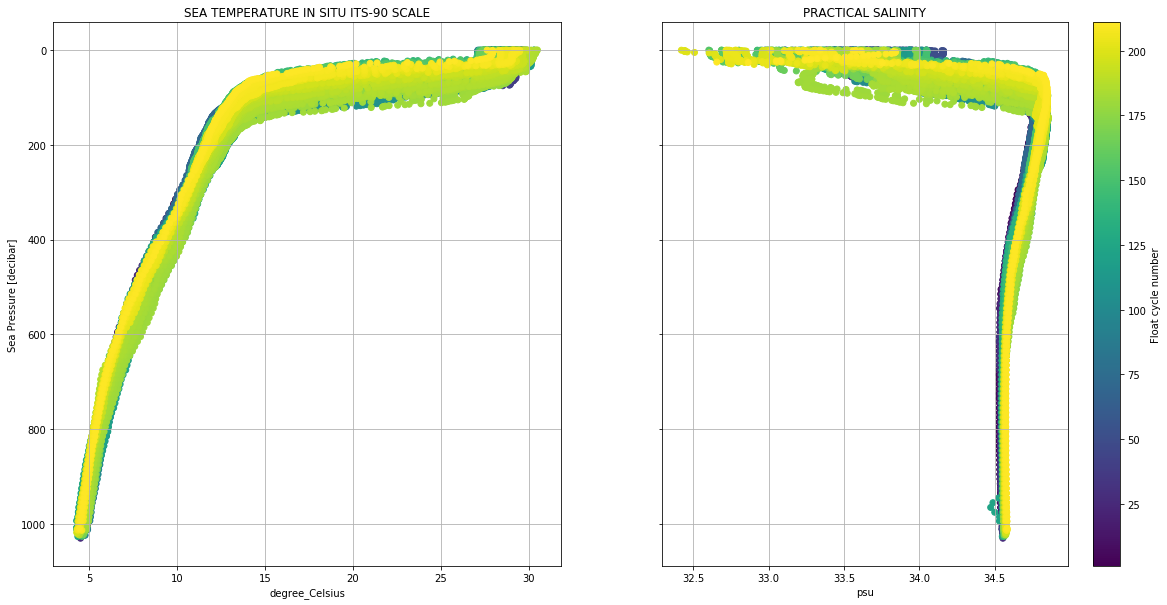

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharey=True)
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(ds['TEMP'], ds['PRES'], c=ds['CYCLE_NUMBER'])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel(ds['TEMP'].attrs['units'])
ax[ix].set_ylabel("%s [%s]" % (ds['PRES'].attrs['long_name'], ds['PRES'].attrs['units']))
ax[ix].set_title(ds['TEMP'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(ds['PSAL'], ds['PRES'], c=ds['CYCLE_NUMBER'])
plt.colorbar(sc, ax=ax[ix], label=ds['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].grid()
ax[ix].set_xlabel(ds['PSAL'].attrs['units'])
ax[ix].set_title(ds['PSAL'].attrs['long_name']);


## T/S diagram

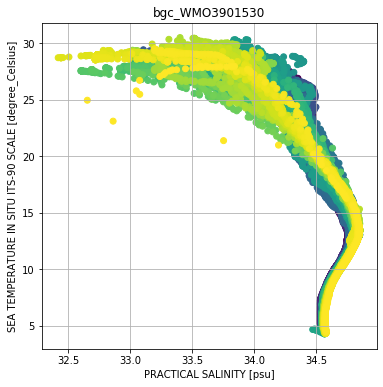

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
ax = np.array(ax).flatten()
ix = 0
sc = ax[ix].scatter(ds['PSAL'], ds['TEMP'], c=ds['CYCLE_NUMBER'])
ax[ix].grid()
ax[ix].set_xlabel("%s [%s]" % (ds['PSAL'].attrs['long_name'], ds['PSAL'].attrs['units']))
ax[ix].set_ylabel("%s [%s]" % (ds['TEMP'].attrs['long_name'], ds['TEMP'].attrs['units']))
plt.title(ds.attrs['Download_constraints']);

# Filter data according to QC flags

In [24]:
# ds_ok = float_fetcher.fetcher.filter_qc(ds) # By default, drop all points with QC not equal to 1 or 2 in all variables
ds_ok = float_fetcher.fetcher.filter_qc(ds, mode='any') # Keep points with at least of the variable QC in 1 or 2
ds_ok

<xarray.Dataset>
Dimensions:          (index: 234964)
Coordinates:
    latitude         (index) float64 15.0 15.0 15.0 15.0 ... 10.19 10.19 10.19
  * index            (index) int64 0 1 2 3 4 ... 234960 234961 234962 234963
    time             (index) datetime64[ns] 2016-11-28T21:00:00 ... 2019-09-17T19:04:00
    longitude        (index) float64 -110.0 -110.0 -110.0 ... -105.3 -105.3
Data variables:
    CYCLE_NUMBER     (index) float64 1.0 1.0 1.0 1.0 ... 211.0 211.0 211.0 211.0
    DATA_MODE        (index) <U1 'A' 'R' 'R' 'R' 'R' 'R' ... 'A' 'R' 'A' 'A' 'R'
    DIRECTION        (index) <U1 'D' 'D' 'D' 'D' 'D' 'D' ... 'A' 'A' 'A' 'A' 'A'
    DOXY             (index) float64 nan nan 187.8 nan ... 21.33 nan nan 23.09
    DOXY_ERROR       (index) float64 nan nan nan nan nan ... nan nan nan nan nan
    DOXY_QC          (index) int64 0 0 1 0 0 0 0 1 0 0 0 ... 1 0 1 0 1 0 1 0 0 1
    PLATFORM_NUMBER  (index) int64 3901530 3901530 3901530 ... 3901530 3901530
    POSITION_QC      (index) int64 8 8 8 8 8 8 8 8 8 8 8 ... 8 8 8 8 8 8 8 8 8 8
    PRES             (index) float64 nan 18.6 18.6 ... 993.0 1.009e+03 1.014e+03
    PRES_ERROR       (index) float64 nan nan nan nan nan ... nan nan nan nan nan
    PRES_QC          (index) int64 0 1 1 1 1 1 0 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    PSAL             (index) float64 nan 33.73 nan nan ... nan 34.58 34.58 nan
    PSAL_ERROR       (index) float64 nan nan nan nan nan ... nan nan nan nan nan
    PSAL_QC          (index) int64 0 1 0 0 1 0 0 0 1 1 0 ... 0 1 0 1 0 1 0 1 1 0
    TEMP             (index) float64 nan 29.4 nan nan ... nan 4.536 4.461 nan
    TEMP_ERROR       (index) float64 nan nan nan nan nan ... nan nan nan nan nan
    TEMP_QC          (index) int64 0 1 0 0 1 0 0 0 1 1 0 ... 0 1 0 1 0 1 0 1 1 0
    TIME_QC          (index) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:               ARGO-BGC
    DOI:                   http://doi.org/10.17882/42182
    Downloaded_from:       http://www.ifremer.fr/erddap
    Downloaded_by:         gmaze
    Download_date:         2020/03/17
    Download_url:          http://www.ifremer.fr/erddap/tabledap/ArgoFloats-b...
    Download_constraints:  bgc_WMO3901530
    history:               Variables selected according to DATA_MODE; Variabl...

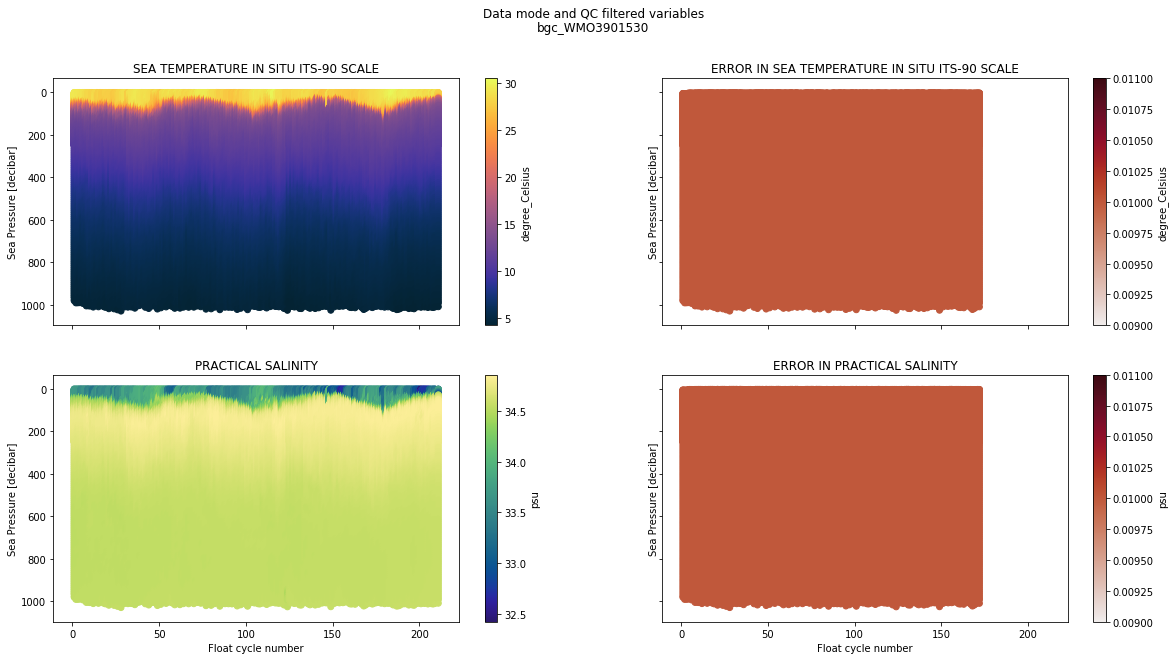

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10), sharex=True, sharey=True)
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(ds_ok['CYCLE_NUMBER'], ds_ok['PRES'], c=ds_ok['TEMP'], cmap=cmocean.cm.thermal)
plt.colorbar(sc, ax=ax[ix], label=ds_ok['TEMP'].attrs['units'])
ax[ix].invert_yaxis()
ax[ix].set_ylabel("%s [%s]" % (ds_ok['PRES'].attrs['long_name'], ds_ok['PRES'].attrs['units']))
ax[ix].set_title(ds_ok['TEMP'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(ds_ok['CYCLE_NUMBER'], ds_ok['PRES'], c=ds_ok['TEMP_ERROR'], cmap=cmocean.cm.amp)
plt.colorbar(sc, ax=ax[ix], label=ds_ok['TEMP_ERROR'].attrs['units'])
ax[ix].set_ylabel("%s [%s]" % (ds_ok['PRES'].attrs['long_name'], ds_ok['PRES'].attrs['units']))
ax[ix].set_title(ds_ok['TEMP_ERROR'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(ds_ok['CYCLE_NUMBER'], ds_ok['PRES'], c=ds_ok['PSAL'], cmap=cmocean.cm.haline)
plt.colorbar(sc, ax=ax[ix], label=ds_ok['PSAL'].attrs['units'])
ax[ix].set_xlabel(ds_ok['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].set_ylabel("%s [%s]" % (ds_ok['PRES'].attrs['long_name'], ds_ok['PRES'].attrs['units']))
ax[ix].set_title(ds_ok['PSAL'].attrs['long_name']);

ix += 1
sc = ax[ix].scatter(ds_ok['CYCLE_NUMBER'], ds_ok['PRES'], c=ds_ok['PSAL_ERROR'], cmap=cmocean.cm.amp)
plt.colorbar(sc, ax=ax[ix], label=ds_ok['PSAL_ERROR'].attrs['units'])
ax[ix].set_xlabel(ds_ok['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].set_ylabel("%s [%s]" % (ds_ok['PRES'].attrs['long_name'], ds_ok['PRES'].attrs['units']))
ax[ix].set_title(ds_ok['PSAL_ERROR'].attrs['long_name']);

fig.suptitle("Data mode and QC filtered variables\n%s" % ds.attrs['Download_constraints']);

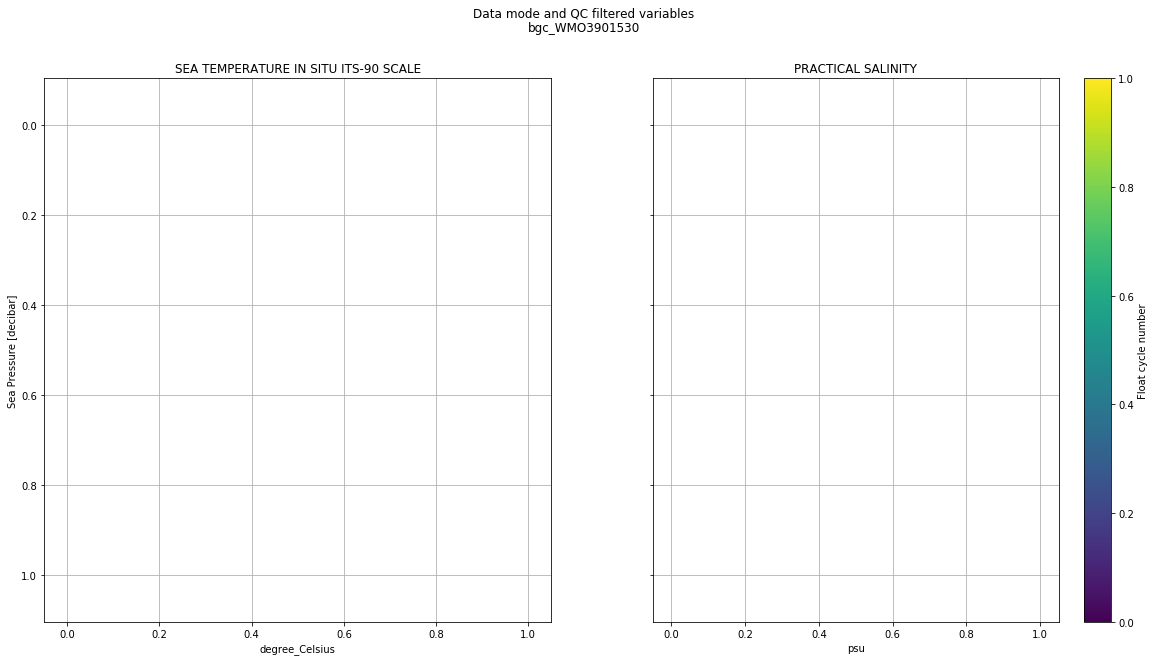

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharey=True)
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(ds_ok['TEMP'], ds_ok['PRES'], c=ds_ok['CYCLE_NUMBER'])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel(ds_ok['TEMP'].attrs['units'])
ax[ix].set_ylabel("%s [%s]" % (ds_ok['PRES'].attrs['long_name'], ds_ok['PRES'].attrs['units']))
ax[ix].set_title(ds_ok['TEMP'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(ds_ok['PSAL'], ds_ok['PRES'], c=ds_ok['CYCLE_NUMBER'])
plt.colorbar(sc, ax=ax[ix], label=ds_ok['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].grid()
ax[ix].set_xlabel(ds_ok['PSAL'].attrs['units'])
ax[ix].set_title(ds_ok['PSAL'].attrs['long_name']);

fig.suptitle("Data mode and QC filtered variables\n%s" % ds.attrs['Download_constraints']);

***
This work is part and was supported by the following projects:
<div>
<img src="https://avatars1.githubusercontent.com/u/58258213?s=460&v=4" width="70"/>
<img src="http://www.argo-france.fr/wp-content/uploads/2019/10/Argo-logo_banner-color.png" width="200"/>
<img src="https://www.umr-lops.fr/var/storage/images/_aliases/logo_main/medias-ifremer/medias-lops/logos/logo-lops-2/1459683-4-fre-FR/Logo-LOPS-2.png" width="70"/>
</div>